# Machine Learning and the Enron Data Set

## Goals and  Introduction

The goal of this project is to analyze Persons of Interest (POI) in the Enron scandal by using machine learning algorithms in order to find patterns of relationships in the data regarding POI that may indicate precursors for fraud. The data set used is a composition of email data collected of 150 senior leaders at Enron and can be found at [this link](https://www.cs.cmu.edu/~./enron/).  

Enron went bankrupt in late 2001 and was considered at the time to be the largest bankruptcy of any organization in American History. The key identifier that led to the cooperation’s downfall has been infamously linked to fraud. I will be analyzing the dataset and exploring key features in this report using machine learning algorithms to set up simulations in which the possibility of fraud could have possibly been red flagged based upon key indicators. For any more information regarding the Enron scandal itself, you may see Wikipedia at [this link](https://en.wikipedia.org/wiki/Enron_scandal).

First thing to do is to import all the packages and tools that will be used throughout the rest of the report.

In [1034]:
#This is first used to import all the packages and tools that will be used throughout the rest of this report
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.metrics import precision_score,recall_score, accuracy_score
from feature_format import featureFormat, targetFeatureSplit
import tester as ts
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3,random_state = 100)
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline 
from sklearn import model_selection
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, labels, test_size=0.3, 
                                                                                             random_state=42)

The code below imports the final data set that will be used to analyze the Enron scandal.

In [1035]:
#This code loads the final data set that I will be using to analyze.
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Data Exploration

The next part will be to load the data as a data frame so that the data can be explored.  I have also added features that will be used later during the algorithms section.

In [1036]:
#loads the data frame
df = pd.DataFrame.from_dict(data_dict, orient='index')


#Adding feature_list to be explored later
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                 'director_fees', 'to_messages', 'email_address', 'from_poi_to_this_person', 
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


After creating the data frame below is an exploration of the data itself. A key note as we move forward is that there are three major categories that financial features will fall into, they are listed below.

**financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

**email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

**POI label:** [‘poi’] (boolean, represented as integer)

**Exploration of the data is listed below.**

First I wanted to look at the data set to check and see if there was a column that specifically had a lot of missing data.  I wanted to see which columns had the most missing values that may be irrelevant to the analysis criteria in the future. Below is that representation of the data.

In [1037]:
#Code to view a count of missing data per column
df[df == 'NaN'] = pd.np.nan
df.isnull().sum()

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64

After reviewing the number of missing data per column I concluded that there are roughly two outlying columns that may not be applicable for this analysis. Those variables are as follows: director fees; loan advances.

In [1038]:
#This code prints the size of the Enron data set
print "Size of Enron Data: ",df.shape

Size of Enron Data:  (146, 21)


In [1039]:
#This code prints the number of features in the Enron data set
print "The number of Features of Enron Data : ",len(df.columns)

The number of Features of Enron Data :  21


In [1040]:
# I wanted to know the number of Persons of Interest. This code counts the number of POIs in the current dataset
poi_count = df.groupby('poi').size()
print "Number of POI's: ",poi_count.iloc[1]

Number of POI's:  18


In [1041]:
# Number of Non-Persons of Interest. This code counts the number of Non-POIs in the current dataset
poi_count = df.groupby('poi').size()
print "Number of POI's: ",poi_count.iloc[0]

Number of POI's:  128


In [1042]:
#Explores the dataframe's values to look for possible clean-up.
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


As you can see from the table above the value Nan needs to be changed to be represented by a 0 to make it easier to view down the line. The code below will fix this function and display the results.

In [1043]:
#Code to fix Nan's
df = df.replace(np.nan, 0) ## Changes 
df.head() #Quick eye audit

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,0,2195,152,65,False,0,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,0,0,False,0,0,0,0,0
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,0,29,864523,0,False,0,-5104,0,james.bannantine@enron.com,39
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,0,2660303,0,False,0,-1386055,1586055,0,0
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,0,69,0,False,0,-201641,0,frank.bay@enron.com,0


## Outlier and Feature Investigation

**Scatter plot of Total Payments vs Total Stock Value**

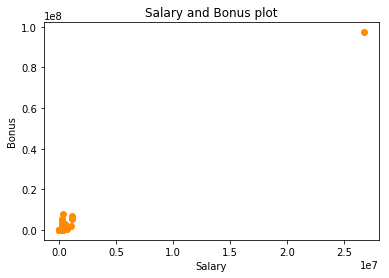

In [1044]:
plt.scatter(df['salary'],df['bonus'],color = 'DarkOrange')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Salary and Bonus plot")
plt.show()

There is a clear outlier when we look at the scatter plot above. Below I have targeted the outlier for viewing and removal.

In [1045]:
#Finding the outlier that is show in the above scatterplot
df['bonus'].idxmax()

'TOTAL'

Since the TOTAL is actually the outlier, this make complete sense. I have removed this row from the data in the below code.

In [1046]:
# Deleting the row 'Total'
df.drop('TOTAL', axis = 0, inplace = True)

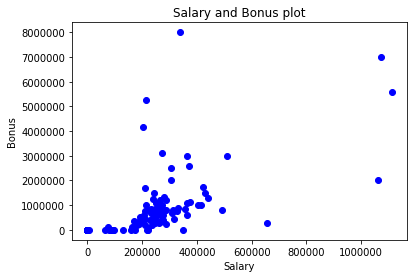

In [1047]:
#Re-running the scatter plot to get a better look at the data after removing the outlier.
plt.scatter(df['salary'],df['bonus'],color = 'b')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Salary and Bonus plot")
plt.show()

After reviewing the above scatter plot, I became curious as to what that data would look like when comparing Persons of Interest vs. those that are not of interest. The below scatter plot includes the above data after removal of the outlier while also showing POIs vs Non-POIs.

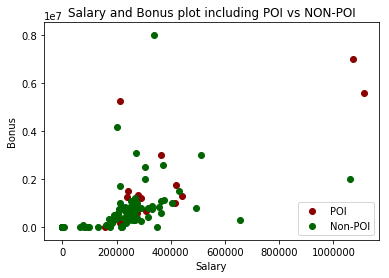

In [1048]:
#Re-running the scatter plot to include the POI vs Non-POI differencial.
plt.scatter(df['salary'][df['poi'] == True],df['bonus'][df['poi'] == True], color = 'darkred',
           label = 'POI')
plt.scatter(df['salary'][df['poi'] == False],df['bonus'][df['poi'] == False],color = 'darkgreen',
           label = 'Non-POI')   
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Salary and Bonus plot including POI vs NON-POI")
plt.legend(loc='lower right')
plt.show()

Based upon this scatterplot it is clear that the POIs have a higher salary and Bonus structure as a general rule. I believe that this may be future in the future so I have created an additional feature below.

In [1049]:
# New Feature
df['bonus_to_salary_differencial'] = df['bonus'] / df['salary']

**Scatter plot of Restricted Stock vs Restricted Stock Deferred**

Since looking at the difference in the POIs vs Non-POIs, I have look at the data for Restricted Stock based upon those two parameters below.

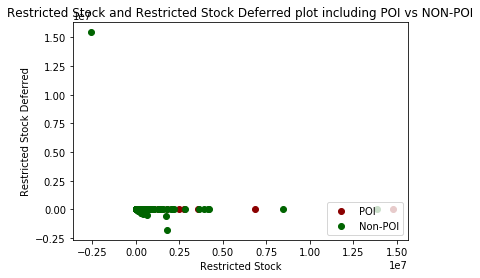

In [1050]:
# Restricted_stock vs restricted_stock_deferred including POIs vs Non-POIs
plt.scatter(df['restricted_stock'][df['poi'] == True],df['restricted_stock_deferred'][df['poi'] == True], color = 'darkred',
           label = 'POI')
plt.scatter(df['restricted_stock'][df['poi'] == False],df['restricted_stock_deferred'][df['poi'] == False],color = 'darkgreen',
           label = 'Non-POI')   
plt.xlabel("Restricted Stock")
plt.ylabel("Restricted Stock Deferred")
plt.title("Restricted Stock and Restricted Stock Deferred plot including POI vs NON-POI")
plt.legend(loc='lower right')
plt.show()

In [1051]:
#Finding the outlier in the scatterplot above
df['restricted_stock_deferred'].idxmax()

'BHATNAGAR SANJAY'

The following code is removing the above outlier who happens to not be a person of interest.

In [1052]:
#Coding dropping the outlier from the dataframe
df.drop('BHATNAGAR SANJAY', axis = 0, inplace = True)

I then wanted to rerun the data to get a better view of the assortment of data via scatterplot.

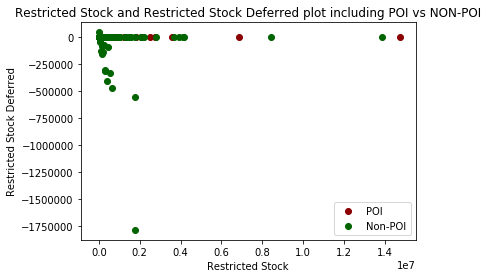

In [1053]:
# Restricted_stock vs restricted_stock_deferred including POIs vs Non-POIs
plt.scatter(df['restricted_stock'][df['poi'] == True],df['restricted_stock_deferred'][df['poi'] == True], color = 'darkred',
           label = 'POI')
plt.scatter(df['restricted_stock'][df['poi'] == False],df['restricted_stock_deferred'][df['poi'] == False],color = 'darkgreen',
           label = 'Non-POI')   
plt.xlabel("Restricted Stock")
plt.ylabel("Restricted Stock Deferred")
plt.title("Restricted Stock and Restricted Stock Deferred plot including POI vs NON-POI")
plt.legend(loc='lower right')
plt.show()

After reviewing the scatterplot, it would appear that most of the Restricted Stock is close to 0 which makes sense considering the 0 values that was ran earlier in this report. The person with the most Restricted Stock that was deferred also happens to be a Non-POI. The feature may be a non-starter as I continue this analysis.

**Features Chosen**

After doing some analysis and outlier clean up, I have decided to use a majority of the features that were given in the original final project pickle file. I have decided to also remove email_address since there isn't really any data that can be gained other than nomenclature. Really the removal of outliers and some of the features were largely due to common sense and critical thinking. The next section will narrow down the features even more so using a univariate tuning parameter. The code below will remove email_address. The list following the code is all features that will be used moving forward including the bonus vs salary differential which was created above.

In [1054]:
#Dropping email address column
df.drop(['email_address'], axis=1)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,bonus_to_salary_differencial
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,0,2195,152,65,False,0,-3081055,304805,47,20.672922
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,0,0,False,0,0,0,0,NaN
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,0,29,864523,0,False,0,-5104,0,39,0.000000
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,0,2660303,0,False,0,-1386055,1586055,0,4.492666
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,0,69,0,False,0,-201641,0,0,1.668955
BAZELIDES PHILIP J,80818,0,684694,860136,1599641,0,0,0,0,1599641,...,0,0,874,0,False,0,0,93750,0,0.000000
BECK SALLY W,231330,7315,0,969068,0,700000,126027,2639,0,126027,...,0,4343,566,386,False,0,0,0,144,3.025980
BELDEN TIMOTHY N,213999,7991,2144013,5501630,953136,5249999,157569,5521,0,1110705,...,0,484,210698,108,True,0,-2334434,0,228,24.532820
BELFER ROBERT,0,0,-102500,102500,3285,0,0,0,44093,-44093,...,0,0,0,0,False,3285,0,0,0,NaN
BERBERIAN DAVID,216582,0,0,228474,1624396,0,869220,0,0,2493616,...,0,0,0,0,False,0,0,0,0,0.000000


After noticing the row called The Travel Agency in the Park, I decided that wasn't a person and removed the line from the dataset below.

In [1055]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
df.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

#### Features that will be used moving forward marked for future feature selection using recursive function:

* poi
* salary
* bonus
* to_messages
* deferral_payments	
* director_fees
* total_payments	
* exercised_stock_options	
* restricted_stock	
* shared_receipt_with_poi	
* restricted_stock_deferred	
* total_stock_value	
* expenses
* other
* loan_advances
* from_messages	
* from_this_person_to_poi		
* deferred_income	
* long_term_incentive	
* from_poi_to_this_person	
* bonus_to_salary_differencial

## Feature Selection

The following is code that has been used to set the feature list and setting a data dictionary that mimics the updates I've made to the data frame throughout this report. Additionally, the code directly below is setting the scaler and skb functions used in the algorithms below.

**Scaler Function**
For anyone that has taken a class on statistics, they will be aware of something called a Z-score. A Z-score is basically a measurement of the number of standard deviations away from the data's mean(average). By using the scaler function the code is able to standardize to a "scale", which is very helpful in machine learning and algorithms. The function scales the data from a measurement of 1 - 0.

**SelectKBest Function**
This function is primarily used to boost the estimates of the algorithm by increasing its accuracy and subsequent efficacy. This function works as a univariate pre-process that essentially selects the best features that will work prior to running the estimator portion itself.

In [1056]:
#This code is first uploading the dataframe and the corresponding changes into my_dataset for further exploration 
my_dataset = df.to_dict(orient="index")

data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#This next code is setting the features as defined by the above list.
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'deferral_payments', 'expenses', 
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income', 'total_payments',
                 'other', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options',
                'total_stock_value', 'restricted_stock']




In [1057]:
# Defining features to be used for the pipeline and feature selection and algorithm selection
## 1. Feature scaling
scaler = MinMaxScaler()

## 2. Feature Selection
skb = SelectKBest(f_classif)

## Choosing an Algorithm 

During this project I have used the following two algorithms for testing: KNN classifier; Gaussian Naive Bayes (GaussianNB) classifier.

These are the next two codes listed below.

One of the first steps is to tune each of the algorithms. This is just a fancy way of selecting the best parameter that will work in each given situation or algorithm. The danger of not tuning an algorithm is that there could be a high number of variance and/or bias. I've used the number of neighbors algorithm from skylearn to tune the KNN classifier below.

In [1058]:
#KNN classifier
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(p = 4)

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3,random_state = 100)
pipeline = Pipeline(steps = [("scaling", scaler), ("SKB", skb),  ("knn",clf_knn)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18], 
              "knn__n_neighbors": [3,4,5,6,7,8,9,11,12,13,15],
              }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
#clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# best algorithm
clf = grid.best_estimator_

t0 = time()
# refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"


print "Accuracy: ",accuracy_score(labels_test, prediction)
print "Precision: ",precision_score(prediction, labels_test)
print "Recall: ",recall_score(prediction, labels_test)
print "f1-score: ",f1_score(prediction, labels_test)

training time:  18.621 s
testing time:  0.004 s
Accuracy:  0.813953488372093
Precision:  0.16666666666666666
Recall:  0.25
f1-score:  0.2


In [1059]:
# Gaussian Naive Bayes (GaussianNB) classifier
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("SKB", skb), ("NaiveBayes",clf_gnb)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# best algorithm
clf = grid.best_estimator_

t0 = time()
# refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy: ",accuracy_score(labels_test, prediction)
print "Precision: ",precision_score(prediction, labels_test)
print "Recall: ",recall_score(prediction, labels_test)
print "f1-score: ",f1_score(prediction, labels_test)

training time:  0.544 s
testing time:  0.008 s
Accuracy:  0.8604651162790697
Precision:  0.3333333333333333
Recall:  0.5
f1-score:  0.4


**Based upon the Precision and Recall of the above two algorithms the Gaussian Naive Bayes represents the most appropriate algorithm to use in the future for this data set.**

In [1060]:
# Creating a dataframe and viewing each feature based upon their scores. 
imp_features_df = pd.DataFrame({'Features_Selected':features_selected_list, 'Features_score':feature_selected_scores})
imp_features_df.sort_values('Features_score', ascending = False,inplace = True)
imp_features_df.set_index(Rank, inplace = True)
imp_features_df

,Features_Selected,Features_score
1,salary,38.519906
2,from_this_person_to_poi,17.553427
3,to_messages,16.246031
4,shared_receipt_with_poi,10.266041
5,deferral_payments,9.392271
6,loan_advances,9.357287
7,restricted_stock,9.253536
8,fraction_mail_from_poi,7.681345
9,total_payments,7.337169
10,long_term_incentive,6.514293


## Evaluation and Validation

Model validation is basically where a trained model is used with the data set. In this report the validation that was used was StratifiedShuffleSplit because the dataset itself if fairly small. One of the most important reasons to use validation is for the fine-tuning of parameters. 

The evaluation metrics used in this report are listed below and were taken from a link in the references text file associated with this report.

* Accuracy is a ratio of correctly predicted observation to the total observations.
$ Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$

* Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
$ precision = (\frac{TP}{TP + FP}) $

* Recall is the ratio of correctly predicted positive observations to the all observations in actual class :
$ recall = (\frac{TP}{TP + FN}) $

* F1-score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
$ f1 = 2.(\frac{precision.recall}{precision + recall}) $